In [1]:
import pandas as pd
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
set_labels =['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                 'Fibrosis','Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
                 'Pneumonia','Pneumothorax']
    
## convert to Multilabels 
mlb = MultiLabelBinarizer(classes=set_labels)
mlb.fit(set_labels)

MultiLabelBinarizer(classes=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
          sparse_output=False)

In [4]:
def label2vector(label):
    
    ## INPUT : ['Atelectasis', 'Cardiomegaly']
    ## OUTPUT : [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    label = [label]
    test_labels_str = [i.split('|') for i in label]
    test_labels_str = [ x if 'Finding' not in x[0] else [] for x in (test_labels_str)]
    return mlb.transform(test_labels_str)[0]

def get_vector_labels(path, is_test):
    
    ## INPUT : ('../data/images/, True)
    ## OUTPUT : 
    
#         img_filename	             vector
# 44187   00013774_026.png    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
# 44188   00013774_028.png    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    
    
    ## read list of non-blacklisted images; train and test 
    if not is_test:
        train_img_list = pd.read_pickle(path + "train_val_filtered.pkl")
    else:
        train_img_list = pd.read_pickle(path + "test_filtered.pkl")
        
    ## read images in our images folder 
    single_tar_images = [i.split('/')[1] for i in glob.glob(path + '*.png')]
    ## subset 
    train_img_list = train_img_list[train_img_list['img_filename'].isin(single_tar_images)]
    
    train_img_list['vector'] = train_img_list['text_label'].apply(label2vector)
    train_img_list = train_img_list[['img_filename', 'vector']]
    return train_img_list

def train_val_splitter(train_df, percentage = 0.1):
    
    assert percentage <= 1
    assert percentage > 0
    
    ## INPUT :  training_df of the shape (n,2), 0 <float <=1
    ## OUTPUT : validation_df, train_df; no patient overlap in the two dfs
                # validation_Df.shape = ~(n*percentage,2), 
                # train_df.shape = ~(n*(1-percentage), 2)
    
    col_list = train_df.columns.tolist()
    
    train_df['patient'] = train_df.img_filename.apply(lambda x : x.split("_")[0])
    valid_patients = np.random.choice(train_df.patient.unique(), 
                 int(train_df.patient.unique().shape[0]*percentage),
                 replace=False)
    
    valid_df = train_df[train_df['patient'].isin(valid_patients)]
    dummy = train_df[~train_df['patient'].isin(valid_patients)]
    
    # assert no rows are missed 
    assert valid_df.shape[0] + dummy.shape[0] == train_df.shape[0]
    # assert intersection is null
    assert np.intersect1d(valid_df.patient.values, dummy.patient.values).tolist() == []
    
    return valid_df[col_list], dummy[col_list]

In [5]:
train_df = get_vector_labels(path = 'images/', is_test = False)
test_df = get_vector_labels(path = 'images/', is_test = True)
valid_df, train_df = train_val_splitter(train_df, 0.2)
print (valid_df.shape, train_df.shape, test_df.shape)

(12385, 2) (49459, 2) (16759, 2)


In [6]:
y_train = np.vstack(train_df.vector.values)
class_dist_train = np.sum(y_train, axis = 0)

set_labels.append("No Finding")

class_dist_train = np.append(class_dist_train, np.sum(np.sum(y_train, axis = 1) == 0))

y_valid = np.vstack(valid_df.vector.values)
class_dist_valid = np.round(np.sum(y_valid, axis = 0),1)
class_dist_valid = np.append(class_dist_valid,np.sum(np.sum(y_valid, axis = 1) == 0))

class_dist_valid = np.round(class_dist_valid*100/y_valid.shape[0],1)
class_dist_train = np.round(class_dist_train*100/y_train.shape[0],1)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


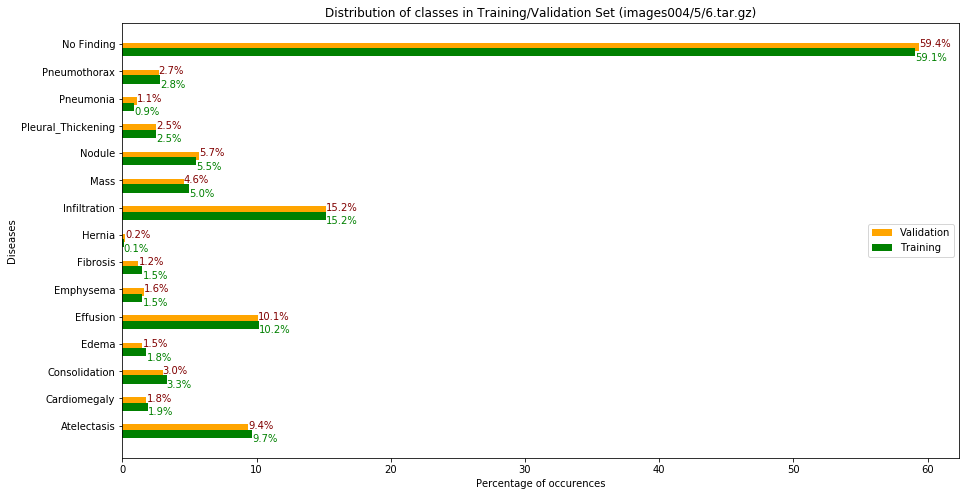

In [7]:
plt.rcParams['figure.figsize'] = [15,8]
axis_font = {'fontname':'Arial', 'size':'10'}

ind = np.arange(len(set_labels))
width = 0.3

ax = plt.subplot(111)    
ax.barh(ind + 0.2, class_dist_valid,width,  color='orange', align = 'center', label="Validation")
ax.barh(ind, class_dist_train, width, color="green", align = 'center', label="Training")
ax.set_yticklabels( set_labels)
ax.set_yticks(ind+width)
plt.title('Distribution of classes in Training/Validation Set (images004/5/6.tar.gz)')
plt.xlabel('Percentage of occurences')
plt.ylabel('Diseases') 
for i,v in enumerate([j for i,j in (list(zip(set_labels, class_dist_train)))]):
    ax.text(v , i - width , str(v) + '%' ,color = 'green', **axis_font)
for i,v in enumerate([j for i,j in (list(zip(set_labels, class_dist_valid)))]):    
    ax.text(v , i + width/2 + 0.05 , str(v) + '%' ,color='maroon', **axis_font)
    
plt.legend(loc = 'center right')
plt.show()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


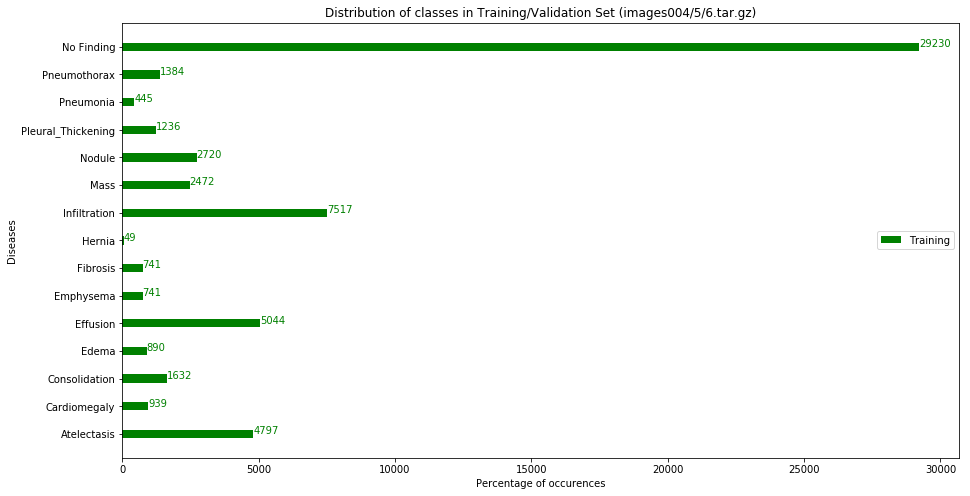

In [8]:
plt.rcParams['figure.figsize'] = [15,8]
axis_font = {'fontname':'Arial', 'size':'10'}

ind = np.arange(len(set_labels))
width = 0.3

ax = plt.subplot(111)    
# ax.barh(ind + 0.2, class_dist_valid,width,  color='orange', align = 'center', label="Validation")
ax.barh(ind, np.round(class_dist_train*y_train.shape[0]/100), width, color="green", align = 'center', label="Training")
ax.set_yticklabels( set_labels)
ax.set_yticks(ind)
plt.title('Distribution of classes in Training/Validation Set (images004/5/6.tar.gz)')
plt.xlabel('Percentage of occurences')
plt.ylabel('Diseases') 
for i,v in enumerate([j for i,j in (list(zip(set_labels, np.floor(class_dist_train*y_train.shape[0]/100).astype(int))))]):
    ax.text(v , i , str(v) ,color = 'green', **axis_font)
# for i,v in enumerate([j for i,j in (list(zip(set_labels, class_dist_valid)))]):    
#     ax.text(v , i + width/2 + 0.05 , str(v) ,color='maroon', **axis_font)
    
plt.legend(loc = 'center right')
plt.show()

In [9]:
CLASSES = 14
WIDTH = 224
HEIGHT = 224
LR = 0.0001
EPOCHS = 25 #100
# Can scale to max for inference but for training LR will be affected
# Prob better to increase this though on P100 since LR is not too low
# Easier to see when plotted
BATCHSIZE = 32 #64*2
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_SD = [0.229, 0.224, 0.225]

In [10]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import os
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.metrics.ranking import roc_auc_score

In [11]:
assert torch.cuda.is_available()
torch.cuda.get_device_capability(torch.cuda.current_device())

(7, 0)

In [12]:
class XRayDataset(Dataset):

    def __init__(self, train_df, root_dir, transform=None):
        self.df = train_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = torch.FloatTensor(self.df[self.df['img_filename'] == self.df.iloc[idx, 0]]['vector'].values[0])
        #labels = torch.FloatTensor(np.array([0]*14))

        if self.transform is not None:
            image = self.transform(image)

        return image, labels

In [13]:
# WIDTH = 224
# IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_RGB_SD = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)

train_dataset = XRayDataset(train_df,
                                    root_dir= os.path.join(os.getcwd() + '/images/'), 
                           transform=transforms.Compose([
                           transforms.Resize(WIDTH),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomResizedCrop(size=WIDTH),
                            transforms.ColorJitter(0.15, 0.15),
                            transforms.RandomRotation(15),
                           transforms.ToTensor(),
                           normalize]))

test_dataset = XRayDataset(test_df,
                                    root_dir= os.path.join(os.getcwd() + '/images/'), 
                           transform=transforms.Compose([
                           transforms.Resize(WIDTH),
                           transforms.ToTensor(),
                           normalize]))

valid_dataset = XRayDataset(valid_df,
                                    root_dir= os.path.join(os.getcwd() + '/images/'), 
                           transform=transforms.Compose([
                           transforms.Resize(WIDTH),
                           transforms.ToTensor(),
                           normalize]))

In [14]:
def get_symbol(out_features=CLASSES):
    model = models.densenet.densenet121(pretrained=True)
    # Replace classifier (FC-1000) with (FC-14)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, out_features), 
        nn.Sigmoid())
    # CUDA
    model.cuda()  
    return model

# model = models.densenet.densenet121(pretrained=True)

# model.classifier = nn.Sequential(
#         nn.Linear(model.classifier.in_features, 14),
#         nn.Sigmoid())
# model.cuda()


def init_symbol(sym, lr=LR):
    # torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    opt = optim.Adam(sym.parameters(), lr=lr, betas=(0.9, 0.999))
    criterion = nn.BCELoss()
    scheduler = ReduceLROnPlateau(opt, factor = 0.1, patience = 5, mode = 'min')
    return opt, criterion, scheduler

# optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
# criterion = nn.BCELoss()
# scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

In [15]:
def compute_roc_auc(data_gt, data_pd, mean=False, classes=CLASSES):
    roc_auc = []
    data_gt = data_gt.cpu().numpy()
    data_pd = data_pd.cpu().numpy()
    for i in range(classes):
        roc_auc.append(roc_auc_score(data_gt[:, i], data_pd[:, i]))
        roc_auc = list(np.round(np.array(roc_auc),2))
    if mean:
        roc_auc = np.mean(roc_auc)
    return roc_auc

In [16]:
def train_epoch(model, dataloader, optimizer, criterion, epoch, batch=BATCHSIZE):
    model.train()
    print("Training epoch {}".format(epoch+1))
    loss_val = 0
    loss_cnt = 0
    for data, target in tqdm(dataloader):
        # Get samples
        data = Variable(torch.FloatTensor(data).cuda())
        target = Variable(torch.FloatTensor(target).cuda())
        # Init
        optimizer.zero_grad()
        # Forwards
        output = model(data)
        # Loss
        loss = criterion(output, target)
        # Back-prop
        loss.backward()
        optimizer.step()   
         # Log the loss
        loss_val += loss.data[0]
        loss_cnt += 1
    print("Training loss: {0:.4f}".format(loss_val/loss_cnt))


def valid_epoch(model, dataloader, criterion, epoch, phase='valid', batch=BATCHSIZE):
    model.eval()
    if phase == 'testing':
        print("Testing epoch {}".format(epoch+1))
    else:
        print("Validating epoch {}".format(epoch+1))
    out_pred = torch.FloatTensor().cuda()
    out_gt = torch.FloatTensor().cuda()
    loss_val = 0
    loss_cnt = 0
    for data, target in dataloader:
        # Get samples
        data = Variable(torch.FloatTensor(data).cuda(), volatile=True)
        target = Variable(torch.FloatTensor(target).cuda(), volatile=True)
         # Forwards
        output = model(data)
        # Loss
        loss = criterion(output, target)
        # Log the loss
        loss_val += loss.data[0]
        loss_cnt += 1
        # Log for AUC
        out_pred = torch.cat((out_pred, output.data), 0)
        out_gt = torch.cat((out_gt, target.data), 0)
    loss_mean = loss_val/loss_cnt
    if phase == 'testing':
        print("Test-Dataset loss: {0:.4f}".format(loss_mean))
        print("Test-Dataset AUC: {}".format(compute_roc_auc(out_gt, out_pred)))
    else:
        print("Validation loss: {0:.4f}".format(loss_mean))
        print("Validation AUC: {}".format(compute_roc_auc(out_gt, out_pred)))
        print("Validation AUC: {0:.4f}".format(np.mean(compute_roc_auc(out_gt, out_pred))))
#         print("Validation AUC: {0:.4f}".format(compute_roc_auc(out_gt, out_pred)))
    return loss_mean

def print_learning_rate(opt):
    for param_group in opt.param_groups:
        print("Learining rate: ", param_group['lr'])

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCHSIZE,
                          shuffle=True, num_workers=32, pin_memory=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=8*BATCHSIZE,
                          shuffle=False, num_workers=8, pin_memory=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=8*BATCHSIZE,
                         shuffle=False, num_workers=8, pin_memory=False)

In [18]:
%%time
# Load symbol
azure_chest_xray_sym = get_symbol()

CPU times: user 2.44 s, sys: 604 ms, total: 3.04 s
Wall time: 3.05 s


In [19]:
%%time
# Load optimiser, loss
optimizer, criterion, scheduler = init_symbol(azure_chest_xray_sym)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.74 ms


In [20]:
loss_min = float("inf")    
stime = time.time()

# No-training
valid_epoch(azure_chest_xray_sym, valid_loader, criterion, -1)

# Main train/val/test loop
for j in (range(EPOCHS)):
    train_epoch(azure_chest_xray_sym, train_loader, optimizer, criterion, j)
    loss_val = valid_epoch(azure_chest_xray_sym, valid_loader, criterion, j)
#     test_loss_val = valid_epoch(azure_chest_xray_sym, test_loader, criterion, j, 'testing')
    # LR Schedule
    scheduler.step(loss_val)
    print_learning_rate(optimizer)
    # todo: tensorboard hooks
    # Logging
    if loss_val < loss_min:
        print("Loss decreased. Saving ...")
        loss_min = loss_val
#         torch.save({'epoch': j + 1, 
#                     'state_dict': azure_chest_xray_sym.state_dict(), 
#                     'best_loss': loss_min, 
#                     'optimizer' : optimizer.state_dict()}, 'best_azure_chest_xray_model_v2.pth.tar')
    etime = time.time()
    print("Epoch time: {0:.0f} seconds".format(etime-stime))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Validating epoch 0


  0%|          | 0/1546 [00:00<?, ?it/s]

Validation loss: 0.8270
Validation AUC: [0.52, 0.47, 0.4, 0.32, 0.52, 0.58, 0.52, 0.56, 0.49, 0.48, 0.5, 0.53, 0.49, 0.48]
Validation AUC: 0.4900
Training epoch 1


100%|██████████| 1546/1546 [05:06<00:00,  5.05it/s]


Training loss: 0.1613
Validating epoch 1


  0%|          | 0/1546 [00:00<?, ?it/s]

Validation loss: 0.1425
Validation AUC: [0.77, 0.81, 0.8, 0.88, 0.86, 0.72, 0.72, 0.65, 0.68, 0.74, 0.65, 0.71, 0.67, 0.73]
Validation AUC: 0.7421
Learining rate:  0.0001
Loss decreased. Saving ...
Epoch time: 420 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 2


100%|██████████| 1546/1546 [05:05<00:00,  5.06it/s]

Training loss: 0.1448
Validating epoch 2



  0%|          | 0/1546 [00:00<?, ?it/s]

Validation loss: 0.1366
Validation AUC: [0.79, 0.85, 0.8, 0.89, 0.88, 0.8, 0.72, 0.75, 0.69, 0.79, 0.7, 0.74, 0.72, 0.79]
Validation AUC: 0.7793
Learining rate:  0.0001
Loss decreased. Saving ...
Epoch time: 783 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 3


100%|██████████| 1546/1546 [05:05<00:00,  5.05it/s]

Training loss: 0.1424
Validating epoch 3



  0%|          | 0/1546 [00:00<?, ?it/s]

Validation loss: 0.1346
Validation AUC: [0.8, 0.86, 0.8, 0.89, 0.88, 0.85, 0.76, 0.82, 0.7, 0.82, 0.71, 0.74, 0.73, 0.82]
Validation AUC: 0.7986
Learining rate:  0.0001
Loss decreased. Saving ...
Epoch time: 1146 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 4


100%|██████████| 1546/1546 [05:05<00:00,  5.06it/s]

Training loss: 0.1409
Validating epoch 4



  0%|          | 0/1546 [00:00<?, ?it/s]

Validation loss: 0.1349
Validation AUC: [0.8, 0.86, 0.79, 0.89, 0.88, 0.85, 0.75, 0.87, 0.7, 0.81, 0.72, 0.75, 0.75, 0.82]
Validation AUC: 0.8029
Learining rate:  0.0001
Epoch time: 1508 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 5


100%|██████████| 1546/1546 [05:05<00:00,  5.06it/s]

Training loss: 0.1394
Validating epoch 5



  0%|          | 0/1546 [00:00<?, ?it/s]

Validation loss: 0.1337
Validation AUC: [0.8, 0.88, 0.81, 0.9, 0.88, 0.85, 0.76, 0.83, 0.7, 0.83, 0.73, 0.75, 0.75, 0.83]
Validation AUC: 0.8071
Learining rate:  0.0001
Loss decreased. Saving ...
Epoch time: 1871 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 6


 16%|█▌        | 247/1546 [00:59<05:13,  4.15it/s]Process Process-236:
Process Process-233:
Process Process-238:
Process Process-211:
Process Process-217:
Process Process-239:
Process Process-231:
Process Process-230:
Process Process-219:
Process Process-221:
Process Process-216:
Process Process-218:
Process Process-237:
Process Process-234:
Process Process-223:
Process Process-212:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-224:
Process Process-220:
Process Process-213:
Process Process-222:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-209:
Process Process-215:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-23

  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/proces

  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File 

KeyboardInterrupt
  File "<ipython-input-12-4c827db07e26>", line 14, in __getitem__
    image = Image.open(img_name).convert('RGB')
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/PIL/ImageFile.py", line 236, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-12-4c827db07e26>", line 19, in __getitem__
    image = self.transform(image)
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/synchronize.py", line 96,

KeyboardInterrupt: 